In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Read the data in
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [3]:
# Setup varitional autoencoder architecture with convolutional layers

numIn = 784

latent_dim = 2

x = tf.placeholder(tf.float32, [None, numIn])

init = tf.contrib.layers.xavier_initializer()
x_in = x

# Encoder
x_in = tf.reshape(x_in, (-1, 28, 28, 1))
x_in = tf.layers.conv2d(inputs = x_in, filters=32, kernel_size=[3, 3], padding="valid", activation=tf.nn.leaky_relu) #26
x_in = tf.layers.conv2d(inputs = x_in, filters=32, kernel_size=[3, 3], padding="valid", activation=tf.nn.leaky_relu) #24
x_in = tf.layers.max_pooling2d(inputs = x_in, pool_size = [2, 2], strides = 2) #12
x_in = tf.layers.conv2d(inputs = x_in, filters=64, kernel_size=[3, 3], padding="valid", activation=tf.nn.leaky_relu) #10
x_in = tf.layers.conv2d(inputs = x_in, filters=64, kernel_size=[3, 3], padding="valid", activation=tf.nn.leaky_relu) #8
x_in = tf.layers.max_pooling2d(inputs = x_in, pool_size = [2, 2], strides = 2) #4 (16)
x_in = tf.layers.flatten(x_in)
x_in = tf.layers.dense(x_in, 16 * 64, activation=tf.nn.leaky_relu, kernel_initializer=init)
x_in = tf.layers.dense(x_in, latent_dim * 2, activation=tf.nn.leaky_relu, kernel_initializer=init)
    
z_mean, z_std = x_in[:, :latent_dim], x_in[:, latent_dim:]
noise = tf.random_normal([tf.shape(x)[0], latent_dim], 0, 1,dtype=tf.float32)

samples = z_mean + z_std * noise

# Decoder
x_out = samples
x_out = tf.layers.dense(x_out, 1024, activation=tf.nn.leaky_relu, kernel_initializer=init)
x_out = tf.layers.dense(x_out, 7 * 7 * 128, activation=tf.nn.leaky_relu, kernel_initializer=init)
x_out = tf.reshape(x_out, (-1, 7, 7, 128))
x_out = tf.layers.conv2d_transpose(x_out, 128, kernel_size=[4,4], padding = "same", strides=2, activation=tf.nn.leaky_relu)
x_out = tf.layers.conv2d_transpose(x_out, 1, kernel_size=[4,4], padding = "same", strides=2, activation=tf.nn.leaky_relu)
x_out = tf.layers.flatten(x_out)
x_hat = tf.layers.dense(inputs=x_out, units = numIn, kernel_initializer=init, activation=tf.nn.sigmoid)



In [4]:
# Loss function
generation_weight = 1
latent_weight = 1
generation_loss = tf.reduce_sum(tf.square(x - x_hat)) # l2 loss
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_std) - tf.log(tf.square(z_std)) - 1, 1)
loss = generation_weight * generation_loss + latent_weight * tf.reduce_sum(latent_loss)

# Setup optimizers
train = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
train2 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
train3 = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(loss)

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
saver = tf.train.Saver()
save_path = './vae checkpoint3/chkpt'

In [7]:
batch_size = 256
the_loss = []
loss_curr = None

for epoch in range(10000 + 1):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)

    trainer = train
    if the_loss and the_loss[-1] < 10000:
        trainer = train2
    _, loss_curr = sess.run([trainer, loss], feed_dict={x: batch_xs})
    the_loss.append(loss_curr)

    if epoch % 100 == 0:
        print(epoch, "Batch Loss:", loss_curr)
        

print("Final batch Loss:", loss_curr)


0 Batch Loss: 48376.094
100 Batch Loss: 13505.292
200 Batch Loss: 12779.303
300 Batch Loss: 12090.932
400 Batch Loss: 11409.139
500 Batch Loss: 11065.056
600 Batch Loss: 10495.842
700 Batch Loss: 10741.861
800 Batch Loss: 10403.914
900 Batch Loss: 10179.846
1000 Batch Loss: 9997.804
1100 Batch Loss: 10081.311
1200 Batch Loss: 10984.126
1300 Batch Loss: 10247.385
1400 Batch Loss: 9990.989
1500 Batch Loss: 9951.637
1600 Batch Loss: 9656.575
1700 Batch Loss: 9420.993
1800 Batch Loss: 9759.656
1900 Batch Loss: 9666.08
2000 Batch Loss: 9853.872
2100 Batch Loss: 9511.497
2200 Batch Loss: 9838.045
2300 Batch Loss: 9964.737
2400 Batch Loss: 9558.426
2500 Batch Loss: 9550.04
2600 Batch Loss: 9351.199
2700 Batch Loss: 8996.93
2800 Batch Loss: 9681.3955
2900 Batch Loss: 9246.513
3000 Batch Loss: 9613.654
3100 Batch Loss: 9681.393
3200 Batch Loss: 9360.9
3300 Batch Loss: 8981.665
3400 Batch Loss: 9310.689
3500 Batch Loss: 9402.496
3600 Batch Loss: 9383.058
3700 Batch Loss: 9141.04
3800 Batch Loss:

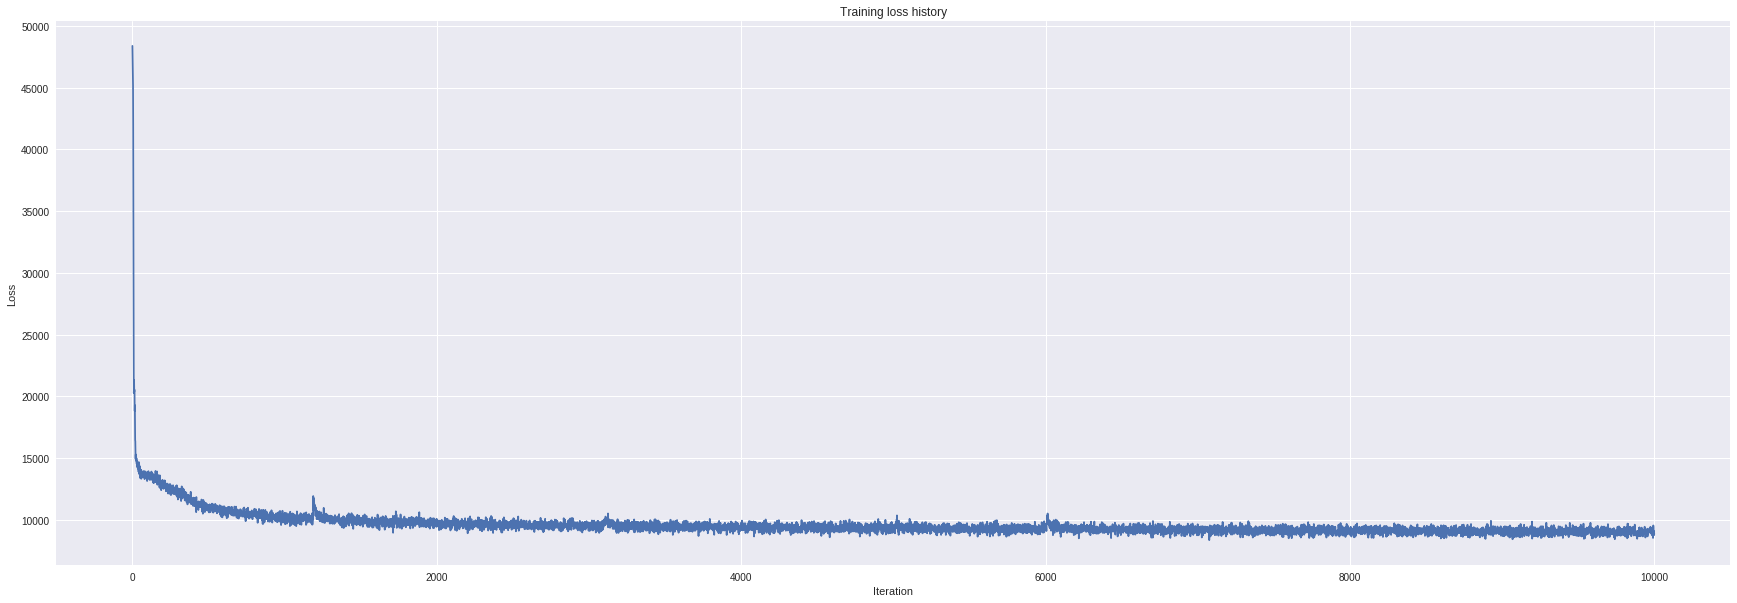

In [8]:
# Loss plot
plt.plot(the_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.gcf().set_size_inches(30, 10)
plt.show()

/device:GPU:0


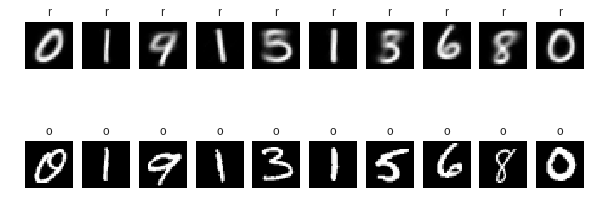

In [9]:
# Show autoencoder reconstruction results for a few
start = 1600
print(tf.test.gpu_device_name())

for i in range(10):
    test_1 = sess.run(x_hat, feed_dict={x: mnist.train.images[start + i:start + i + 1]})
    mean, std = sess.run([z_mean, z_std], feed_dict={x: mnist.train.images[start + i:start + i + 1]})
    out_see = np.clip(test_1, 0, 1)

    plt.subplot(2, 10, i + 1)
    plt.title("r")
    plt.imshow(np.reshape(out_see, (28, -1)), cmap=plt.cm.gray)
    plt.axis('off')

for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.title("o")
    plt.imshow(np.reshape(mnist.train.images[start + i:start + i + 1], (28, -1)), cmap=plt.cm.gray)
    plt.axis('off')
  
plt.gcf().set_size_inches(10, 4)
plt.show()

/device:GPU:0


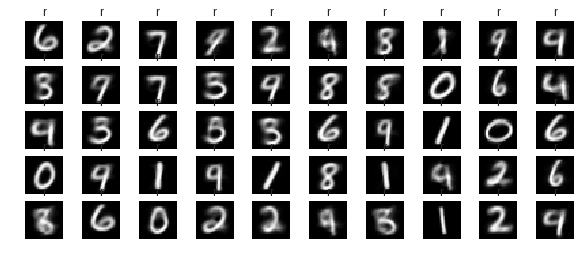

In [10]:
# Show autoencoder latent generation
print(tf.test.gpu_device_name())

for i in range(10):
  
    mean, std = sess.run([z_mean, z_std], feed_dict={x: mnist.train.images[start + i:start + i + 1]})

    for j in range(5):
        sample = np.random.randn(1, latent_dim)
        out_see = sess.run(x_hat, feed_dict={samples: sample})


        plt.subplot(5, 10, i + 1 + j * 10)
        plt.title("r")
        plt.imshow(np.reshape(out_see, (28, -1)), cmap=plt.cm.gray)
        plt.axis('off')


  
plt.gcf().set_size_inches(10, 4)
plt.show()

/device:GPU:0


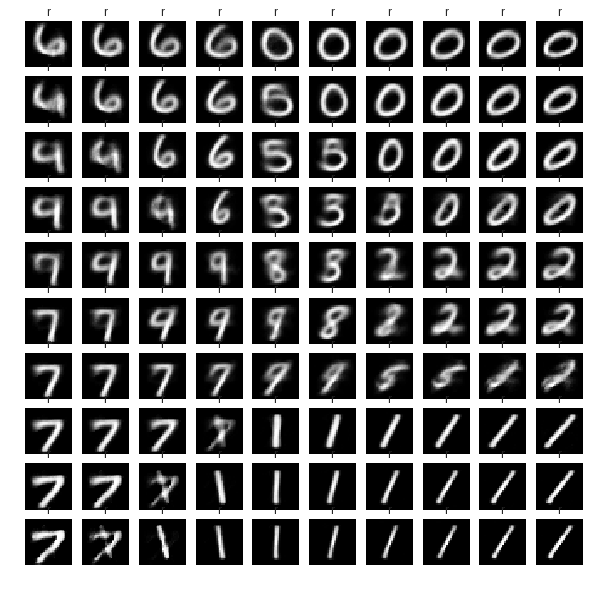

In [20]:
# Show autoencoder latent generation as 2D grid
print(tf.test.gpu_device_name())

for i in range(10):
  for j in range(10):
    sample = [[-2 + i * .5, -2 + j * .5]]
    out_see = sess.run(x_hat, feed_dict={samples: sample})


    plt.subplot(10, 10, i + 1 + j * 10)
    plt.title("r")
    plt.imshow(np.reshape(out_see, (28, -1)), cmap=plt.cm.gray)
    plt.axis('off')


  
plt.gcf().set_size_inches(10, 10)
plt.show()

In [14]:
saver.save(sess, save_path)

'./models/chkpt'

In [ ]:
# Restore checkpoint
saver.restore(sess, save_path)

In [0]:
sess.close()

Future work:
* Test adversarial vae
* Try different datasets (fashion mnist etc)
* Try content loss instead of l2 loss